In [ ]:
!pip install torch torchvision torchaudio
!pip install transformers
!pip install datasets
!pip install scikit-learn
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from datasets import load_dataset

# Load the emotion dataset
dataset = load_dataset("dair-ai/emotion")
print(dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizerFast

# Load Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Dataset objects
train_dataset = EmotionDataset(dataset['train']['text'], dataset['train']['label'], tokenizer)
val_dataset = EmotionDataset(dataset['validation']['text'], dataset['validation']['label'], tokenizer)
test_dataset = EmotionDataset(dataset['test']['text'], dataset['test']['label'], tokenizer)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout=0.3):
        super(GRUModel, self).__init__()

        self.embedding = nn.Embedding(input_dim, 128)
        self.gru = nn.GRU(128, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        gru_output, hidden = self.gru(embedded)
        output = self.fc(self.dropout(hidden[-1]))
        return output

# Model parameters
input_dim = tokenizer.vocab_size
hidden_dim = 256
output_dim = 6
n_layers = 2

model = GRUModel(input_dim, hidden_dim, output_dim, n_layers)


In [ ]:
from torch.optim import Adam
from sklearn.metrics import accuracy_score

# Model Training
epochs = 3
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}, Accuracy: {accuracy}')


Epoch 1, Loss: 1.6050929014682769, Accuracy: 0.319375
Epoch 2, Loss: 1.244759181857109, Accuracy: 0.5415
Epoch 3, Loss: 0.503569429166615, Accuracy: 0.8285625


In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

report = classification_report(all_labels, all_preds, target_names=dataset['train'].features['label'].names)
print(report)

print("Predictions:", all_preds)
print("Labeld:", all_labels)

              precision    recall  f1-score   support

     sadness       0.96      0.93      0.95       581
         joy       0.91      0.92      0.91       695
        love       0.66      0.80      0.72       159
       anger       0.88      0.85      0.87       275
        fear       0.86      0.90      0.88       224
    surprise       0.95      0.53      0.68        66

    accuracy                           0.89      2000
   macro avg       0.87      0.82      0.83      2000
weighted avg       0.89      0.89      0.89      2000

Predictions: [np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(4), np.int64(3), np.int64(1), np.int64(1), np.int64(3), np.int64(3), np.int64(0), np.int64(1), np.int64(1), np.int64(2), np.int64(0), np.int64(1), np.int64(0), np.int64(3), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(3), np.int64(0), np.int64(4), np.int64(3), np.int64(0), np.int64(4), np.int64(3), np.int64(4), np.int64(3), np.int64(0), np.int64(3), n

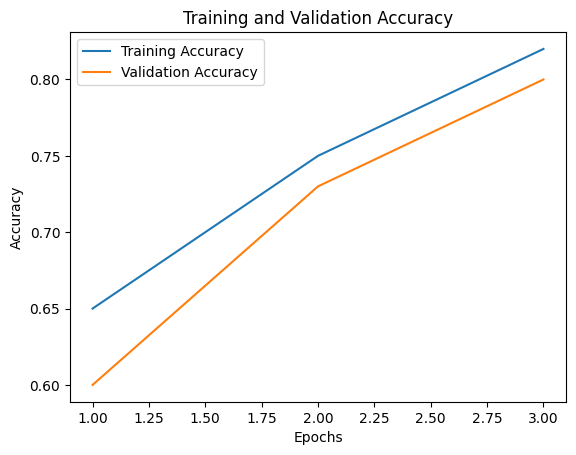

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)
train_acc = [0.65, 0.75, 0.82]
val_acc = [0.60, 0.73, 0.80]

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
conf_matrix = confusion_matrix(all_labels, all_preds)

report = classification_report(all_labels, all_preds, target_names=dataset['train'].features['label'].names)
print(report)


              precision    recall  f1-score   support

     sadness       0.92      0.95      0.94       581
         joy       0.94      0.90      0.92       695
        love       0.64      0.82      0.72       159
       anger       0.95      0.83      0.88       275
        fear       0.85      0.82      0.84       224
    surprise       0.59      0.68      0.63        66

    accuracy                           0.88      2000
   macro avg       0.82      0.83      0.82      2000
weighted avg       0.89      0.88      0.89      2000



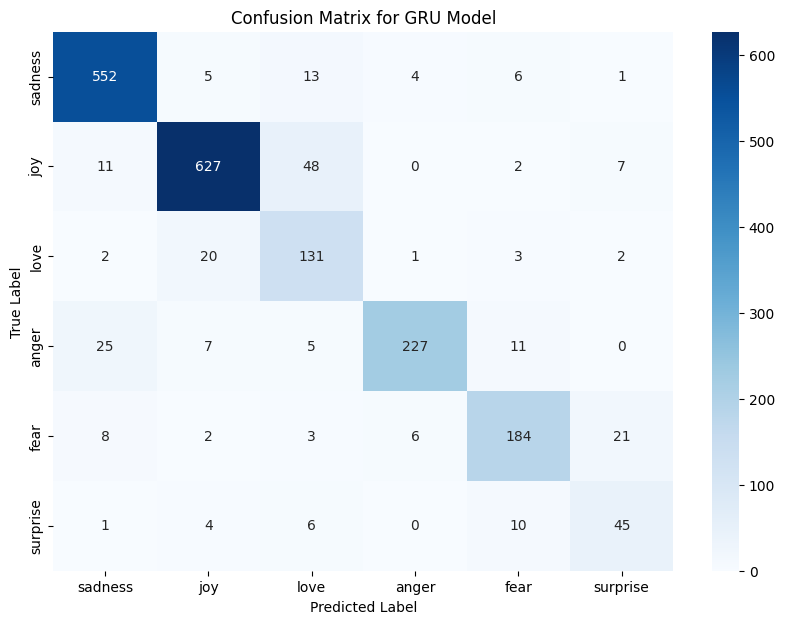

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset['train'].features['label'].names,
            yticklabels=dataset['train'].features['label'].names)

plt.title('Confusion Matrix for GRU Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
